# Image Segmentation using U-Net and Kaggle Carvana Data

All this is the same code as before (fast.ai lesson 14 carvana notebook).

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Import libraries:

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

In [ ]:
# Enable the following line if you have more than 1 GPU
# torch.cuda.set_device(0)

In [3]:
torch.backends.cudnn.benchmark = True

## Data

Setup directory and file paths:

In [4]:
PATH = Path('data/carvana')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH / MASKS_FN)
meta_csv = pd.read_csv(PATH / META_FN)

A helper function for showing images:

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64
nw = 16

In [ ]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 128
bs = 64
nw = 16

In [7]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y = y
        assert(len(fnames) == len(y))
        super().__init__(fnames, transform, path)

    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))

    def get_c(self): return 0

In [8]:
x_names = np.array([Path(TRAIN_DN) / o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN) / f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [9]:
val_idxs = list(range(1008))
((val_x, trn_x), (val_y, trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [10]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [11]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x, trn_y), (val_x, val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [12]:
x, y = next(iter(md.trn_dl))

In [13]:
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 128, 128]))

## Simple upsample

At the start, I've got a simple upsample version just to show you again the non U-net version. This time, I'm going to add in something called the **dice metric**. Dice is very similar, as you see, to Jaccard or I over U. It's just a minor difference. It's basically intersection over union with a minor tweak. The reason we are going to use dice is that's the metric that Kaggle competition used and it's a little bit harder to get a high dice score than a high accuracy because it's really looking at what the overlap of the correct pixels are with your pixels. But it's pretty similar.

So in the Kaggle competition, people that were doing okay were getting about 99.6 dice and the winners were about 99.7 dice.

In [14]:
f = resnet34
cut, lr_cut = model_meta[f]

Base is our base network:

In [15]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [16]:
def dice(pred, targs):
    pred = (pred > 0).float()
    return 2. * (pred * targs).sum() / (pred + targs).sum()

Here is our standard upsample:

In [17]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)

    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [18]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn # resnet
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512, 256),
            StdUpsample(256, 256),
            StdUpsample(256, 256),
            StdUpsample(256, 256),
            nn.ConvTranspose2d(256, 1, 2, stride=2))

    def forward(self, x): return self.features(x)[:, 0]

In [19]:
class UpsampleModel():
    def __init__(self, model, name='upsample'):
        self.model, self.name = model, name
    
    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

In [20]:
m_base = get_base()

In [21]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

In [22]:
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = nn.BCEWithLogitsLoss()
learn.metrics = [accuracy_thresh(0.5), dice]

In [23]:
learn.freeze_to(1)

In [24]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('BatchNorm2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_para

 84%|████████▍ | 54/64 [00:19<00:03,  2.70it/s, loss=2.81] CPU times: user 25.4 s, sys: 4.7 s, total: 30.1 s
Wall time: 20.3 s


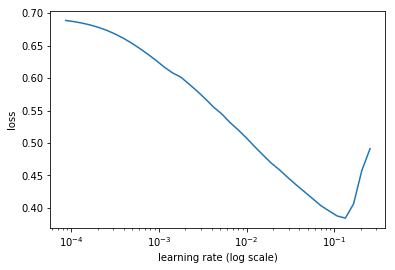

In [25]:
%%time
learn.lr_find()
learn.sched.plot()

In [26]:
lr = 4e-2
wd = 1e-7
lrs = np.array([lr / 100, lr / 10, lr]) / 2

In [27]:
%time learn.fit(lr, 1, wds=wd, cycle_len=4, use_clr=(20, 8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.115094   0.052829   0.977156   0.946632  
    1      0.060572   0.041022   0.981844   0.958449        
    2      0.041211   0.037313   0.981443   0.960839        
    3      0.033257   0.029371   0.986961   0.971081        
CPU times: user 2min 1s, sys: 21.1 s, total: 2min 23s
Wall time: 1min 38s


[array([0.02937]), 0.9869610014415923, 0.9710806340169884]

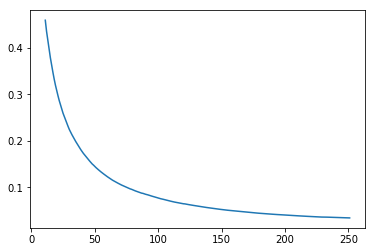

In [28]:
learn.sched.plot_loss()

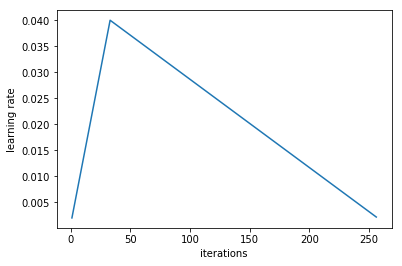

In [29]:
learn.sched.plot_lr()

In [30]:
learn.save('tmp')

In [31]:
learn.load('tmp')

In [32]:
learn.unfreeze()
learn.bn_freeze(True)

In [33]:
learn.fit(lrs, 1, cycle_len=4, use_clr=(20, 8))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.030218   0.028607   0.988389   0.972355  
    1      0.026548   0.02659    0.988868   0.974199        
    2      0.024496   0.025141   0.989952   0.975959        
    3      0.022905   0.024065   0.990201   0.977141        


[array([0.02407]), 0.9902006482321118, 0.9771410902235166]

Now we can check our dice metric. You can see on dice metric, we are getting around 97.7 at 128x128. So that's not great.

In [37]:
learn.save('128')

In [38]:
learn.load('128')

Test the model by running predictions.

In [40]:
x, y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

Predicted version of the mask:

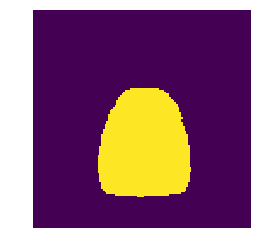

In [41]:
show_img(py[0] > 0)

Ground truth version of the mask:

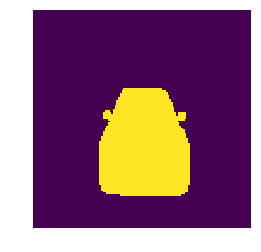

In [42]:
show_img(y[0])

## U-net (ish)

I'm calling it U-net (ish) because as per usual I'm creating my own somewhat hacky version — trying to keep things as similar to what you're used to as possible and doing things that I think makes sense.

So there should be plenty of opportunity for you to at least make this more authentically U-net. There's a few differences. But one of the things is because I want to take advantage of transfer learning — that means I can't quite use U-Net.

What if you create the U-Net down path and then add a classifier on the end and then train that on ImageNet. For now though, we don't have that yet. So we are going to use ResNet.

In [43]:
class SaveFeatures():
    features = None

    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output): self.features = output

    def remove(self): self.hook.remove()

In [44]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out // 2
        self.x_conv = nn.Conv2d(x_in, x_out, 1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p) # up_p is up path
        x_p = self.x_conv(x_p) # x path
        cat_p = torch.cat([up_p, x_p], dim=1) # dim=1 concat from means left to right
        return self.bn(F.relu(cat_p))

In [ ]:
# Reminder to self: last point where I stop writing code.
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()
            


In [ ]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

Base is our base network and that was defined back up in the U-Net section.

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)